In [111]:
import re
# 运行时，要将该.ipynb文件与数据集文件夹lfw_funneled放在同一目录下
female_txt = "lfw_funneled\\female_names.txt"
male_txt = "lfw_funneled\\male_names.txt"
female_name = []
female_pic = []
female_path = []
male_name = []
male_pic = []
male_path = []
with open(female_txt, 'r') as fp:
    pic = fp.readline()
    while pic != "":
        female_pic.append(pic.strip('\n'))
        female_name.append(re.sub('_0....jpg\n', '', pic))
        pic = fp.readline()
with open(male_txt, 'r') as fp:
    pic = fp.readline()
    while pic != "":
        male_pic.append(pic.strip('\n'))
        male_name.append(re.sub('_0....jpg\n', '', pic))
        pic = fp.readline()
for i in range(0, len(male_name)):
    male_path.append('lfw_funneled\\'+ male_name[i] + '\\' + male_pic[i])
for i in range(0, len(female_name)):
    female_path.append('lfw_funneled\\'+ female_name[i] + '\\' + female_pic[i])
    
import random
def SplitData(path,train_set,validation_set,test_set,split_test,split_train):
    test_length=int(len(path)*split_test)
    train_length=int(len(path)*split_train)
    validation_length=int(len(path)-test_length-train_length)
    shuffled_set=random.sample(path,len(path))
    train_set.extend(shuffled_set[:train_length])
    validation_set.extend(shuffled_set[train_length:train_length+validation_length])
    test_set.extend(shuffled_set[train_length+validation_length:])

split_test=0.5
split_train=0.4

male_train_set=[]
male_test_set=[]
male_validation_set=[]
female_train_set=[]
female_test_set=[]
female_validation_set=[]

SplitData(male_path,male_train_set,male_validation_set,male_test_set,split_test,split_train)
SplitData(female_path,female_train_set,female_validation_set,female_test_set,split_test,split_train)

male_train_labels=[1 for _ in range(0,len(male_train_set))]
female_train_labels=[0 for _ in range(0,len(female_train_set))]
male_validation_labels=[1 for _ in range(0,len(male_validation_set))]
female_validation_labels=[0 for _ in range(0,len(female_validation_set))]
male_test_labels=[1 for _ in range(0,len(male_test_set))]
female_test_labels=[0 for _ in range(0,len(female_test_set))]

train_set=male_train_set+female_train_set
train_labels=male_train_labels+female_train_labels
validation_set=male_validation_set+female_validation_set
validation_labels=male_validation_labels+female_validation_labels
test_set=male_test_set+female_test_set
test_labels=male_test_labels+female_test_labels

test_combine=list(zip(test_set,test_labels))
random.shuffle(test_combine)
test_set,test_labels=zip(*test_combine)
validation_combine=list(zip(validation_set,validation_labels))
random.shuffle(validation_combine)
validation_set,validation_labels=zip(*validation_combine)
train_combine=list(zip(train_set,train_labels))
random.shuffle(train_combine)
train_set,train_labels=zip(*train_combine)

print(len(train_set),len(validation_set),len(test_set))

5293 1324 6617


In [112]:
with open("train_set.txt",'w') as fp:
    for i in range(0,len(train_set)):
        fp.write(train_set[i]+"  "+str(train_labels[i])+'\n')
with open("validation_set.txt",'w') as fp:
    for i in range(0,len(validation_set)):
        fp.write(validation_set[i]+"  "+str(validation_labels[i])+'\n')     
with open("test_set.txt",'w') as fp:
    for i in range(0,len(test_set)):
        fp.write(test_set[i]+"  "+str(test_labels[i])+'\n')

In [113]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [114]:
train_images=[]
validation_images=[]
test_images=[]
for i in range(0,len(train_set)): 
    img=cv2.imread(train_set[i])
    detected_face=cv2.resize(img,(75,75))
    detected_face=detected_face.mean(axis=2)
    train_images.append(detected_face)
for i in range(0,len(validation_set)):
    img=cv2.imread(validation_set[i])
    detected_face=cv2.resize(img,(75,75))
    detected_face=detected_face.mean(axis=2)
    validation_images.append(detected_face)
for i in range(0,len(test_set)):
    img=cv2.imread(test_set[i])
    detected_face=cv2.resize(img,(75,75))
    detected_face=detected_face.mean(axis=2)
    test_images.append(detected_face)

In [115]:
model=keras.Sequential()
model.add(keras.layers.Conv2D(48,(3,3),activation='relu',input_shape=(75,75,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(48,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(48,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dense(2,activation=tf.nn.softmax))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 73, 73, 48)        480       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 36, 36, 48)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 34, 34, 48)        20784     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 17, 17, 48)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 15, 15, 48)        20784     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 7, 7, 48)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 2352)            

In [116]:
train_images=np.array(train_images)
train_images_scaled=train_images/255
train_labels=np.array(train_labels)
validation_images=np.array(validation_images)
validation_images_scaled=validation_images/255
validation_labels=np.array(validation_labels)
test_images=np.array(test_images)
test_images_scaled=test_images/255
test_labels=np.array(test_labels)
# print(train_images_scaled.reshape(-1,75,75,1).shape)
# print(len(train_labels))

In [117]:
model.compile(optimizer=tf.optimizers.RMSprop(),loss=tf.losses.sparse_categorical_crossentropy,metrics=['accuracy'])
history=model.fit(train_images_scaled.reshape(-1,75,75,1),train_labels,batch_size=8,validation_data=(validation_images_scaled.reshape(-1,75,75,1),validation_labels),validation_batch_size=1,epochs=8)

Epoch 1/8
662/662 [==============================] - 21s 31ms/step - loss: 0.4109 - accuracy: 0.8184 - val_loss: 0.3331 - val_accuracy: 0.8595
Epoch 2/8
662/662 [==============================] - 22s 33ms/step - loss: 0.2951 - accuracy: 0.8829 - val_loss: 0.2761 - val_accuracy: 0.8897
Epoch 3/8
662/662 [==============================] - 22s 33ms/step - loss: 0.2341 - accuracy: 0.9065 - val_loss: 0.2422 - val_accuracy: 0.9131
Epoch 4/8
662/662 [==============================] - 21s 32ms/step - loss: 0.2014 - accuracy: 0.9227 - val_loss: 0.1932 - val_accuracy: 0.9282
Epoch 5/8
662/662 [==============================] - 21s 32ms/step - loss: 0.1654 - accuracy: 0.9405 - val_loss: 0.2041 - val_accuracy: 0.9252
Epoch 6/8
662/662 [==============================] - 21s 32ms/step - loss: 0.1421 - accuracy: 0.9418 - val_loss: 0.2074 - val_accuracy: 0.9343
Epoch 7/8
662/662 [==============================] - 23s 34ms/step - loss: 0.1258 - accuracy: 0.9537 - val_loss: 0.1872 - val_accuracy: 0.9328

<Figure size 432x288 with 0 Axes>

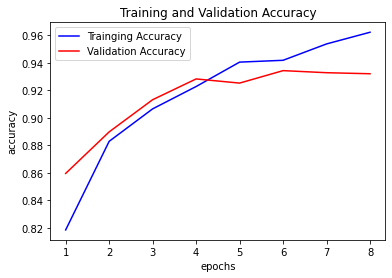

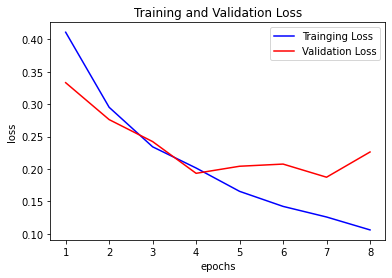

<Figure size 432x288 with 0 Axes>

In [134]:
acc=history.history['accuracy']
loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
epochs=range(1,1+len(acc))

plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Trainging Accuracy','Validation Accuracy'])
plt.figure()

plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Trainging Loss','Validation Loss'])
plt.figure()

In [119]:
model.evaluate(test_images_scaled.reshape(-1,75,75,1),test_labels,batch_size=1)

6617/6617 [==============================] - 8s 1ms/step - loss: 0.2168 - accuracy: 0.9246


[0.21679186820983887, 0.9245882034301758]

In [120]:
# detector=cv2.CascadeClassifier("C:\\Users\\admin\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml")

In [121]:
# def Catch_Face_And_Predict(imgpath): # 先捕捉脸再预测，捕捉脸时准确性低。
#     img=cv2.imread(imgpath)
#     plt.imshow(img)
#     faces=detector.detectMultiScale(img)
#     if len(faces)>0:
#         x,y,w,h=faces[0]
#         detected_face=img[int(y):int(y+h),int(x):int(x+w)]
#         detected_face=cv2.resize(detected_face,(75,75))
#         detected_face=detected_face.mean(axis=2)
#     else:
#         detected_face=cv2.resize(img,(75,75))
#         detected_face=detected_face.mean(axis=2)
#     detected_face=np.array(detected_face)/255
#     _=model.predict([[detected_face.reshape(-1,75,75,1)]])
#     print("Predict:")
#     if np.argmax(_)==0:
#         print("female")
#     else:
#         print("male")

In [122]:
def Direct_Predict(imgpath): # 直接预测，准确性高。
    img=cv2.imread(imgpath)
    plt.imshow(img)
    img=cv2.resize(img,(75,75))
    img=img.mean(axis=2)
    img=np.array(img)/255
    _=model.predict([[img.reshape(-1,75,75,1)]])
    print("Predict:")
    if np.argmax(_)==0:
        print("female")
    else:
        print("male")

Predict:
female


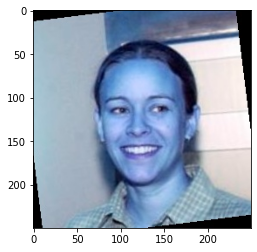

In [130]:
Direct_Predict(test_set[3])

Predict:
male


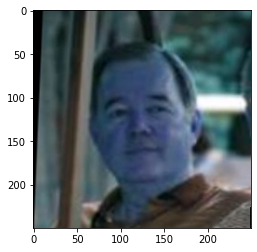

In [131]:
Direct_Predict(validation_set[3])

Predict:
male


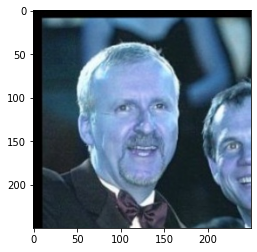

In [132]:
Direct_Predict(train_set[3])

In [126]:
model.save("model_with_validation.h5")

In [ ]:
# 加载模型
# model=tf.keras.models.load_model("model_with_validation.h5")